In [2]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt

## $\textcolor{green}{\text{Optimizers}}$
So far, we have been using SGD (Stochastic Gradient Descent) as our optimizer. In the last lecture, we added momentum to it as well. Here we will look what momentum means and what other optimizers we can use.

The formula for regular SGD is $$w_{t+1} = w_t-\alpha \cdot g_t,$$ where $\alpha$ is our learning rate and $g_t$ is gradient at step $t$. The gradient can be computed over the whole dataset, a batch or a single data point; though normally we use mini-batch SGD (going over randomly chosen batches). This works well using GPU and is simple to compute. However, SGD is quite slow to converge (it can wiggle a lot) and more importantly, it can get stuck in local minimums or saddle points. 

---
## $\textcolor{green}{\text{Momentum}}$
Momentum is a way to add smoother and faster convergence that can reduce a chance to get trapped by local extrema or saddle points. The idea is to use previous gradients as part of computation of new gradients by means of exponential averaging. So now our weight update is $$ w_{t+1} = w_{t}-\alpha \cdot v_t, \text{ where } v_t=\beta v_{t-1}+(1-\beta)g_t$$

Note we have another parameter $\beta$ (this is the value we used as `momentum`). So, if $\beta=0.9$, then we will use 10% of current gradient and 90% of previous exponentially averaged gradients. To see the last part, compute the first $n$ values of $v_t$:

$$v_0=0$$
$$v_1=\beta v_0-(1-\beta)g_1=-(1-\beta)g_1$$
$$v_2=\beta v_1 - (1-\beta)g_2=-\beta (1-\beta)g_1-(1-\beta)g_2=-(1-\beta)(g_2+\beta g_1)$$
$$v_3=\beta v_2 - (1-\beta)g_3=-\beta (1-\beta)(g_2+\beta g_1)-(1-\beta)g_3=-(1-\beta)(g_3+\beta g_2+\beta^2 g_1)$$

Following above steps we can get get to $v_n$:
$$v_n=-(1-\beta)(g_n+\beta g_{n-1}+\beta^2 g_{n-2}+ \cdots + \beta^{n-1}g_1)$$

Since we are using previous gradients, we reduced the oscilation and so we speed up the convergence. Moreover, it speeds up convergence over flat regions. The value 0.9 is the usually picked value for momentum.

Another optimizer that can be viewed as improved version of momentum optimizers is Nesterov optimizers. 

---
## $\textcolor{green}{\text{AdaGrad}}$

AdaGrad stands for Adaptive Gradient. The adaptive part refers to changing learning rate. The idea is as follows: large gradient means we can overshoot and small gradient means we converge too slow. AdaGrad uses sum of squares of previous gradients to change learning rate. If gradient was too large, learning rate will decrease and if it was too small, learning rate will increase. The formula for it is $$w_{t+1}=w_{t}-\frac{\alpha}{\sqrt{s_t+\epsilon}}\cdot g_t, \text{where } s_t=s_{t-1}+g_t^2$$

Here, $\epsilon$ is a very small value that helps us to avoid division by zero. Usually it is around $10^{-8}$, but you will almost never need to set it to anything.

So with AdaGrad we dont have to manually change learning rate, the algorithm adapts by itself. The main drawback is that accumulated squared gradient may decrease learning rate too fast stopping convergence too soon. However, this optimizer works well with sparse data.

---
## $\textcolor{green}{\text{RMSProp}}$


This is an amalgamation of AdaGrad and exponential averaging idea. The formula is as follows: $$w_{t+1}=w_t-\frac{\alpha}{\sqrt{s_{t+1}+\epsilon}} \cdot g_t, \text{ where } s_{t+1}=\beta s_t+(1-\beta)g_t^2$$

So this optimizer fixes a problem of disapearing learning rate of AdaGrad since we are prioritizing previous gradients a bit more. Usual value for $\beta$ is 0.999.

Another optimizers that falls into Adaptive type optimizers that also tries to fix problem is AdaGrad is AdaDelta. It also doesn't use global learning rate at all.

---
## $\textcolor{green}{\text{Adam}}$


Adam is basically RMSProp plus momentum. So, the formula now is:

$$ w_{t+1}=w_t-\frac{\alpha}{\sqrt{s_{t+1}+\epsilon}} \cdot v_{t+1}, $$
where
$$v_{t+1}=\frac{\beta_1 v_t+(1-\beta_1)g_t}{1-\beta_1^t}, \text{ and } s_{t+1}=\frac{\beta_2 s_t+(1-\beta_2)g_t^2}{1-\beta_2^t}$$

The numerators of $v_{t+1}$ and $s_{t+1}$ are exactly the momentum and exponetial average of RMSprop respectively. The denominators are called bias correction, which is used to correct initial choice of weights (being biased towards zero).

This optimizer is quite powerful. In essence, it combines all good properties of momentum and RMSProp.


There are other optimizers that try to improve on Adam in various ways such as AdamW, Adamax, Nadam, Lars, and many many more. 

---
## $\textcolor{green}{\text{Comparison of Optimizers}}$


The following website has nice animation comparing convergence of SGD, SGD with momentum, RMSProp and Adam based on starting point (note the left extrema is global minimum, and the right one is local minimum) (https://emiliendupont.github.io/2018/01/24/optimization-visualization/)

Finally, lets compare some these optimizers on our big CNN model. To make my timing a bit more reliable and faster, I will use GPU insted of CPU. Since GPU are designed to be more efficient with mathematical computation, we often use them for deep neural networks.
<div class="alert alert-block alert-info"><b>Note:</b>
 To do this, I will set up device as $cuda$ and then move my models and all data to GPU using $.to(device)$. Note that NumPy doesn't work with GPU and you can't combine things that are in GPU with things that are on CPU, so if you need to move something from GPU to CPU you can use $.detach().cpu().numpy()$.</div>


#### $\textcolor{red}{\text{Example}}$

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class AnimalCNN(nn.Module):
    
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.convolution_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=1, padding=1),   #in = 3x32x32; out = 32x32x32
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1),   #in = 32x32x32; out = 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))      # in = 32x32x32:  out = 32x16x16
        )
        self.linear_stack=nn.Sequential(
            nn.Linear(32*16*16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,10)
        )

    def forward(self, x):
        x = self.convolution_stack(x)
        x=self.flatten(x)
        x=self.linear_stack(x)
        return x


In [6]:
def get_acc_loss(model, loader):
    correct=0
    total=0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        output=model(images)
        pred = output.data.max(1, keepdim=True)[1]
        total+=labels.shape[0]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        loss=loss_func(output, labels)
    acc=100.*correct/total
    return acc.detach().cpu().numpy(), loss.detach().cpu().numpy()

In [7]:
n_epochs=20
loss_func = nn.CrossEntropyLoss()

<div class="alert alert-block alert-info"><b>Note:</b>
Below I am moving model to GPU</div>

In [8]:
test_loss_SGD = []
test_acc_SGD=[]

model_SGD=AnimalCNN().to(device)
optimizer = torch.optim.SGD(model_SGD.parameters(), lr=0.001)

<div class="alert alert-block alert-info"><b>Note:</b>
Notice below I am moving images and labels to GPU as well</div>

In [9]:
%%time

for epoch in range(n_epochs):
    model_SGD.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_SGD(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_SGD.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_SGD, testloader)            
        test_acc_SGD.append(acc)
        test_loss_SGD.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=2.27, Test Accuracy=10.9
Epoch 2/20, Test Loss=2.28, Test Accuracy=18.0
Epoch 3/20, Test Loss=2.23, Test Accuracy=22.2
Epoch 4/20, Test Loss=2.01, Test Accuracy=27.2
Epoch 5/20, Test Loss=1.92, Test Accuracy=30.8
Epoch 6/20, Test Loss=2.1, Test Accuracy=32.1
Epoch 7/20, Test Loss=1.9, Test Accuracy=33.6
Epoch 8/20, Test Loss=1.61, Test Accuracy=33.6
Epoch 9/20, Test Loss=2.04, Test Accuracy=34.9
Epoch 10/20, Test Loss=1.59, Test Accuracy=35.5
Epoch 11/20, Test Loss=1.75, Test Accuracy=36.6
Epoch 12/20, Test Loss=1.7, Test Accuracy=37.0
Epoch 13/20, Test Loss=2.03, Test Accuracy=37.0
Epoch 14/20, Test Loss=1.54, Test Accuracy=38.0
Epoch 15/20, Test Loss=1.55, Test Accuracy=38.7
Epoch 16/20, Test Loss=2.04, Test Accuracy=39.4
Epoch 17/20, Test Loss=1.93, Test Accuracy=39.9
Epoch 18/20, Test Loss=1.69, Test Accuracy=41.1
Epoch 19/20, Test Loss=1.82, Test Accuracy=40.3
Epoch 20/20, Test Loss=1.82, Test Accuracy=41.6
CPU times: total: 3min 29s
Wall time: 2min 25s


In [10]:
test_loss_Momentum = []
test_acc_Momentum=[]

model_Momentum=AnimalCNN().to(device)
optimizer = torch.optim.SGD(model_Momentum.parameters(), lr=0.001, momentum=0.9)

In [11]:
%%time

for epoch in range(n_epochs):
    model_Momentum.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_Momentum(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_Momentum.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_Momentum, testloader)            
        test_acc_Momentum.append(acc)
        test_loss_Momentum.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=1.86, Test Accuracy=33.4
Epoch 2/20, Test Loss=1.65, Test Accuracy=39.4
Epoch 3/20, Test Loss=2.07, Test Accuracy=42.9
Epoch 4/20, Test Loss=1.68, Test Accuracy=44.8
Epoch 5/20, Test Loss=1.25, Test Accuracy=47.1
Epoch 6/20, Test Loss=1.38, Test Accuracy=48.7
Epoch 7/20, Test Loss=1.14, Test Accuracy=49.6
Epoch 8/20, Test Loss=1.33, Test Accuracy=51.4
Epoch 9/20, Test Loss=1.31, Test Accuracy=53.3
Epoch 10/20, Test Loss=0.853, Test Accuracy=53.7
Epoch 11/20, Test Loss=0.956, Test Accuracy=56.0
Epoch 12/20, Test Loss=1.61, Test Accuracy=56.8
Epoch 13/20, Test Loss=0.864, Test Accuracy=58.5
Epoch 14/20, Test Loss=1.76, Test Accuracy=59.6
Epoch 15/20, Test Loss=0.765, Test Accuracy=60.6
Epoch 16/20, Test Loss=1.41, Test Accuracy=61.7
Epoch 17/20, Test Loss=1.34, Test Accuracy=62.9
Epoch 18/20, Test Loss=1.18, Test Accuracy=64.0
Epoch 19/20, Test Loss=0.957, Test Accuracy=64.7
Epoch 20/20, Test Loss=1.05, Test Accuracy=65.5
CPU times: total: 3min 26s
Wall time: 2min 2

In [12]:
test_loss_Adagrad = []
test_acc_Adagrad=[]

model_Adagrad=AnimalCNN().to(device)
optimizer = torch.optim.Adagrad(model_Adagrad.parameters(), lr=0.001)

In [13]:
%%time

for epoch in range(n_epochs):
    model_Adagrad.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_Adagrad(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_Adagrad.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_Adagrad, testloader)            
        test_acc_Adagrad.append(acc)
        test_loss_Adagrad.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=1.66, Test Accuracy=39.4
Epoch 2/20, Test Loss=1.62, Test Accuracy=41.8
Epoch 3/20, Test Loss=1.73, Test Accuracy=43.5
Epoch 4/20, Test Loss=1.47, Test Accuracy=45.0
Epoch 5/20, Test Loss=1.49, Test Accuracy=45.3
Epoch 6/20, Test Loss=1.3, Test Accuracy=45.7
Epoch 7/20, Test Loss=1.81, Test Accuracy=46.5
Epoch 8/20, Test Loss=1.52, Test Accuracy=47.2
Epoch 9/20, Test Loss=1.64, Test Accuracy=46.6
Epoch 10/20, Test Loss=1.43, Test Accuracy=46.9
Epoch 11/20, Test Loss=1.16, Test Accuracy=47.2
Epoch 12/20, Test Loss=1.37, Test Accuracy=47.2
Epoch 13/20, Test Loss=1.79, Test Accuracy=47.7
Epoch 14/20, Test Loss=1.56, Test Accuracy=49.1
Epoch 15/20, Test Loss=1.52, Test Accuracy=49.0
Epoch 16/20, Test Loss=1.37, Test Accuracy=49.3
Epoch 17/20, Test Loss=1.42, Test Accuracy=49.6
Epoch 18/20, Test Loss=1.22, Test Accuracy=48.9
Epoch 19/20, Test Loss=1.25, Test Accuracy=49.9
Epoch 20/20, Test Loss=1.23, Test Accuracy=50.1
CPU times: total: 3min 33s
Wall time: 2min 30s


In [14]:
test_loss_RMSprop = []
test_acc_RMSprop=[]

model_RMSprop=AnimalCNN().to(device)
optimizer = torch.optim.RMSprop(model_RMSprop.parameters(), lr=0.001, alpha=0.999)

In [15]:
%%time

for epoch in range(n_epochs):
    model_RMSprop.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_RMSprop(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_RMSprop.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_RMSprop, testloader)            
        test_acc_RMSprop.append(acc)
        test_loss_RMSprop.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=2.19, Test Accuracy=30.4
Epoch 2/20, Test Loss=1.77, Test Accuracy=44.7
Epoch 3/20, Test Loss=1.3, Test Accuracy=54.4
Epoch 4/20, Test Loss=1.03, Test Accuracy=55.2
Epoch 5/20, Test Loss=1.09, Test Accuracy=62.0
Epoch 6/20, Test Loss=1.1, Test Accuracy=61.6
Epoch 7/20, Test Loss=0.371, Test Accuracy=68.8
Epoch 8/20, Test Loss=0.94, Test Accuracy=69.1
Epoch 9/20, Test Loss=0.851, Test Accuracy=65.9
Epoch 10/20, Test Loss=0.56, Test Accuracy=75.5
Epoch 11/20, Test Loss=0.86, Test Accuracy=74.6
Epoch 12/20, Test Loss=1.2, Test Accuracy=79.1
Epoch 13/20, Test Loss=0.391, Test Accuracy=83.3
Epoch 14/20, Test Loss=0.465, Test Accuracy=82.7
Epoch 15/20, Test Loss=0.531, Test Accuracy=84.2
Epoch 16/20, Test Loss=0.617, Test Accuracy=85.3
Epoch 17/20, Test Loss=0.581, Test Accuracy=90.8
Epoch 18/20, Test Loss=0.296, Test Accuracy=91.5
Epoch 19/20, Test Loss=0.207, Test Accuracy=91.6
Epoch 20/20, Test Loss=0.113, Test Accuracy=91.4
CPU times: total: 3min 30s
Wall time: 2min

In [16]:
test_loss_Adam = []
test_acc_Adam=[]

model_Adam=AnimalCNN().to(device)
optimizer = torch.optim.Adam(model_Adam.parameters(), lr=0.001, betas=(0.9,0.999))

In [17]:
%%time

for epoch in range(n_epochs):
    model_Adam.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_Adam(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_Adam.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_Adam, testloader)            
        test_acc_Adam.append(acc)
        test_loss_Adam.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=1.33, Test Accuracy=54.5
Epoch 2/20, Test Loss=0.957, Test Accuracy=64.0
Epoch 3/20, Test Loss=0.917, Test Accuracy=69.3
Epoch 4/20, Test Loss=0.978, Test Accuracy=74.1
Epoch 5/20, Test Loss=0.799, Test Accuracy=77.3
Epoch 6/20, Test Loss=0.742, Test Accuracy=79.8
Epoch 7/20, Test Loss=0.277, Test Accuracy=82.7
Epoch 8/20, Test Loss=0.393, Test Accuracy=85.3
Epoch 9/20, Test Loss=0.202, Test Accuracy=87.1
Epoch 10/20, Test Loss=0.312, Test Accuracy=88.7
Epoch 11/20, Test Loss=0.367, Test Accuracy=89.8
Epoch 12/20, Test Loss=0.592, Test Accuracy=91.7
Epoch 13/20, Test Loss=0.391, Test Accuracy=92.6
Epoch 14/20, Test Loss=0.335, Test Accuracy=93.2
Epoch 15/20, Test Loss=0.0814, Test Accuracy=95.0
Epoch 16/20, Test Loss=0.159, Test Accuracy=95.0
Epoch 17/20, Test Loss=0.046, Test Accuracy=96.4
Epoch 18/20, Test Loss=0.101, Test Accuracy=97.1
Epoch 19/20, Test Loss=0.143, Test Accuracy=97.2
Epoch 20/20, Test Loss=0.0764, Test Accuracy=97.2
CPU times: total: 3min 32s
W

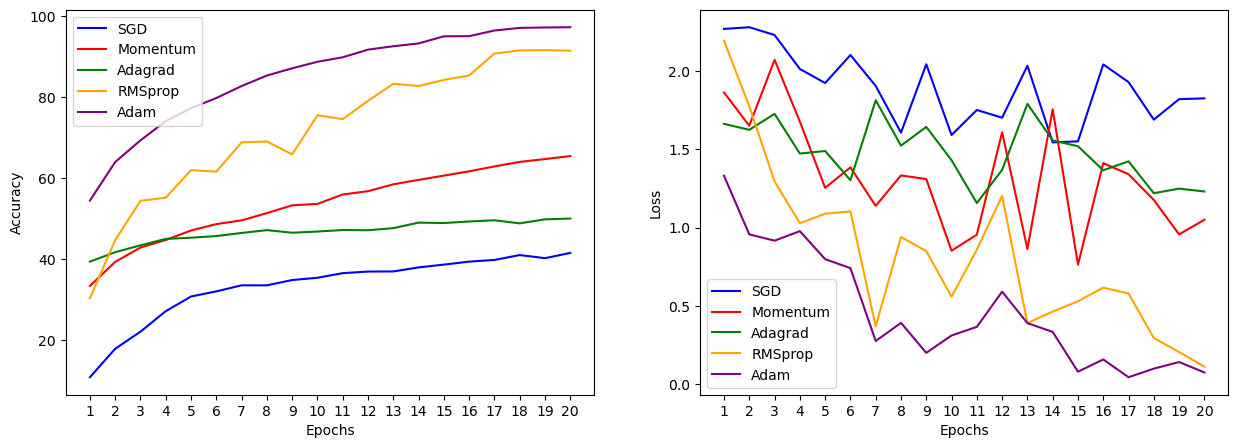

In [18]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc_SGD, color='blue', label='SGD')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc_Momentum, color='red', label='Momentum')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc_Adagrad, color='green',label='Adagrad')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc_RMSprop, color='orange',label='RMSprop')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc_Adam, color='purple',label='Adam')
ax[0].legend(loc='upper left')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(np.arange(1,n_epochs+1, 1))

ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss_SGD, color='blue', label='SGD')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss_Momentum, color='red', label='Momentum')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss_Adagrad, color='green',label='Adagrad')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss_RMSprop, color='orange',label='RMSprop')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss_Adam, color='purple',label='Adam')
ax[1].legend( loc='lower left')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(np.arange(1,n_epochs+1, 1))

plt.show()

For comparison, here is SGD run on CPU. Note that times will differ based on your hardware. 

In [19]:
device=torch.device("cpu")

In [21]:
test_loss_SGD_CPU = []
test_acc_SGD_CPU=[]

model_SGD_CPU=AnimalCNN().to(device)
optimizer = torch.optim.SGD(model_SGD_CPU.parameters(), lr=0.001)

In [22]:
%%time

for epoch in range(n_epochs):
    model_SGD_CPU.train()
    for idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model_SGD_CPU(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model_SGD_CPU.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model_SGD_CPU, testloader)            
        test_acc_SGD_CPU.append(acc)
        test_loss_SGD_CPU.append(loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/20, Test Loss=2.3, Test Accuracy=14.6
Epoch 2/20, Test Loss=2.33, Test Accuracy=18.7
Epoch 3/20, Test Loss=2.35, Test Accuracy=23.2
Epoch 4/20, Test Loss=2.14, Test Accuracy=28.4
Epoch 5/20, Test Loss=2.15, Test Accuracy=31.0
Epoch 6/20, Test Loss=1.85, Test Accuracy=32.1
Epoch 7/20, Test Loss=1.91, Test Accuracy=33.0
Epoch 8/20, Test Loss=1.97, Test Accuracy=33.5
Epoch 9/20, Test Loss=1.97, Test Accuracy=35.0
Epoch 10/20, Test Loss=2.0, Test Accuracy=35.4
Epoch 11/20, Test Loss=2.29, Test Accuracy=36.6
Epoch 12/20, Test Loss=1.94, Test Accuracy=37.1
Epoch 13/20, Test Loss=1.87, Test Accuracy=38.3
Epoch 14/20, Test Loss=1.6, Test Accuracy=38.4
Epoch 15/20, Test Loss=1.83, Test Accuracy=39.8
Epoch 16/20, Test Loss=1.88, Test Accuracy=40.3
Epoch 17/20, Test Loss=1.72, Test Accuracy=40.7
Epoch 18/20, Test Loss=1.66, Test Accuracy=41.0
Epoch 19/20, Test Loss=1.47, Test Accuracy=40.9
Epoch 20/20, Test Loss=1.75, Test Accuracy=41.8
CPU times: total: 3h 32min 15s
Wall time: 13min 2s
